### Explore the data

Tasks 
<ul>
    <li> Clearning, imputing missing values</li>
    <li> Correlation analysis, correspondace analysis</li>
    <li> Plots</li>
<ul>



In [14]:
import pandas as pd 
import numpy as np
import seaborn as sns

%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)


In [2]:
df = pd.read_csv(r'data\data.csv', header=0)

In [3]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

The 5000 missing data on shot_made_flag are left out for testing purpose. We should consider separating those

In [98]:
test = df[df['shot_made_flag'].isnull()]
df = df.loc[df.index.difference(test.index)]

#### Plot of shots made and missed

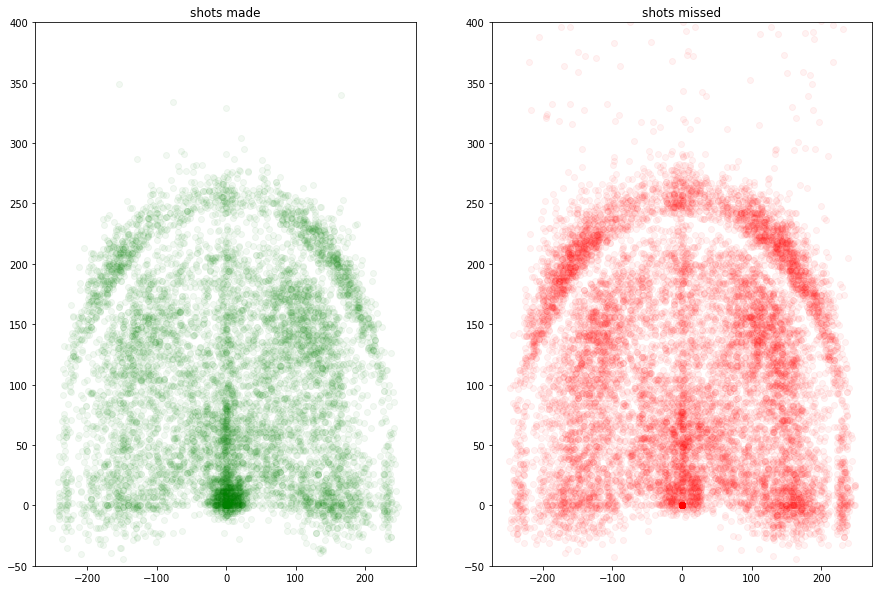

In [100]:
alpha = .05

plt.subplot(121)
made = df[df['shot_made_flag']==1]
plt.scatter(made['loc_x'], made['loc_y'], c='green', alpha=alpha)
plt.ylim([-50, 400])
plt.title('shots made')

plt.subplot(122)
miss = df[df['shot_made_flag']==0]
plt.scatter(miss['loc_x'], miss['loc_y'], c='red', alpha=alpha)
plt.ylim([-50, 400])
plt.title('shots missed')


plt.show()

He seems to prefer shots that are either directly inline with the basket, or at a ~25 degree angle from it. he also misses a lot when he's under the basket/ on the right side of the basket when angle=0. That could be a flag.

#### shot zone vs accuracy

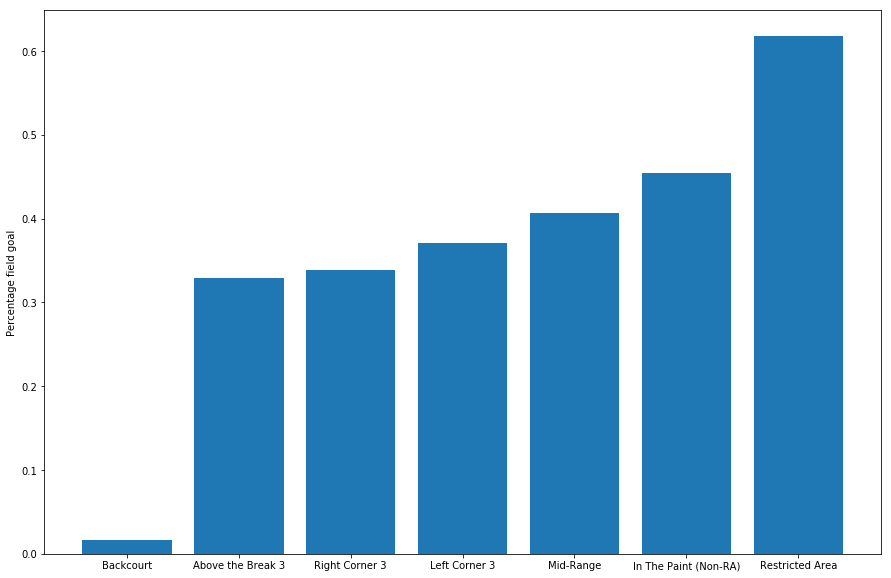

In [101]:
acc_zone = df.groupby('shot_zone_basic').mean()['shot_made_flag'].sort_values()
plt.bar(range(7), acc_zone)
plt.xticks(range(7), acc_zone.index)
plt.ylabel('Percentage field goal')
plt.show()

#### Calculate distance, angle from the basket using x and y coordinates

In [106]:
df['distance'] = np.sqrt(df['loc_x']**2 + df['loc_y']**2)

# calculate the angle using radians, measuring from the x axis
# since law of reflection says the incident angle is the same as angle of reflection,
# it's more likely that Kobe would consider the incident angle instead of the polar angle when 
# he taks a shot, we need to convert that. The normal vector to the backboard is at radians pi/2
df['angle'] = np.arccos(df['loc_x']/250)
df['incident_angle'] = np.abs(np.pi/2 - df['angle'])

# doing the above assumes symmetricit across the normal vector pointing out from the basket, we must add back the 
# side of the basket he's in. We do this by simply 

df['side'] = np.sign(np.pi/2 - df['angle'])

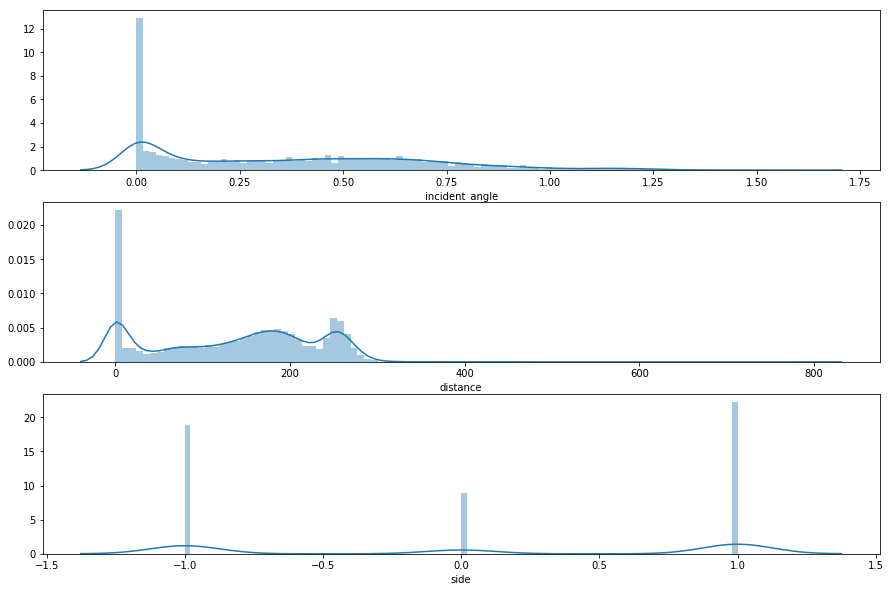

In [115]:
plt.subplot(311)
sns.distplot(df['incident_angle'], bins=100)

plt.subplot(312)
sns.distplot(df['distance'], bins=100)

plt.subplot(313)
sns.distplot(df['side'], bins=100)

What are the relationships between these variables and the shots that he's made?

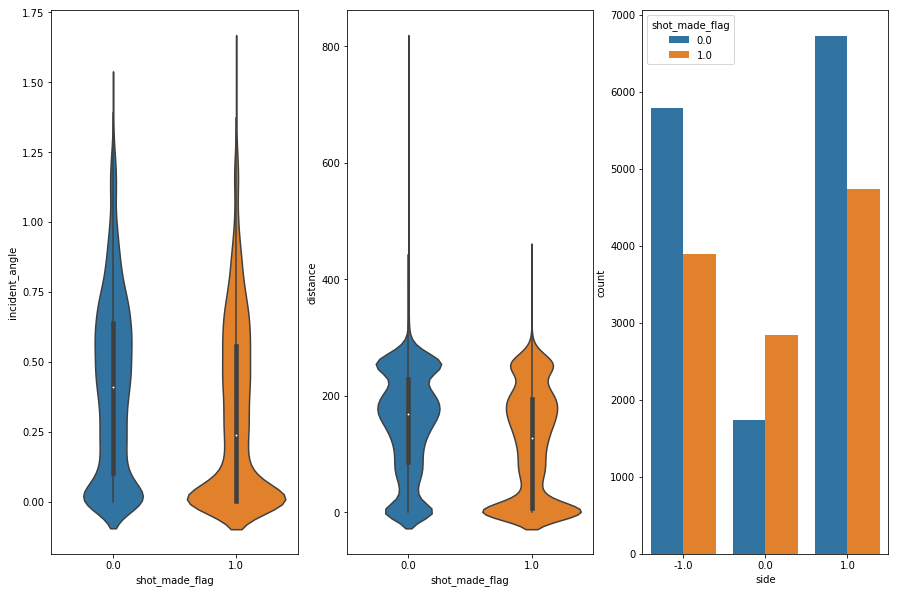

In [128]:
plt.subplot(131)
sns.violinplot('shot_made_flag', 'incident_angle', data=df)

plt.subplot(132)
sns.violinplot('shot_made_flag', 'distance', data=df)

plt.subplot(133)
sns.countplot('side', hue='shot_made_flag', data=df)


Interesting, it seems that he's much more likely to make a shot if he's perpendicular to the basket. And he's preferred shot corner is on the right, but the actual accuracy does not deviate much from the left.



#### Psychological factors

Stuff like time remaining, period, playoffs etc...

minutes_remaining is the minutes remaining in that quater and seconds remaining is the seconds reamining in that minute. Combining them we see the tota time termaining in the quater.


In [131]:
df['time_remaining'] = df['minutes_remaining'] * 60 + df['seconds_remaining']

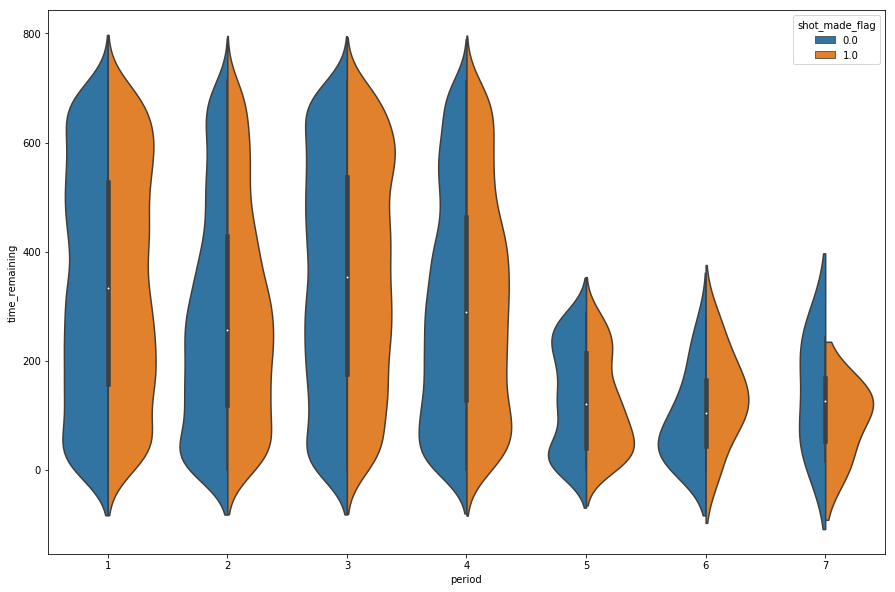

In [134]:
sns.violinplot('period', 'time_remaining', hue='shot_made_flag', data=df, split=True)
plt.show()

### Possible features to use

- Rolling lagged average shots made per quater.
- Distance of shot away from "hot zone" (zone where his shot made percentages is the highest)
- Rolling lagged average of shots made against each team.
- A quantized difficulty of the shot he's making. (distance, type, 2pt, 3pt, time remaining)
- 手感 Is he "feeling it" before the shot? (stuff like field goal percentage in that game)
- Laker's winning streak 
- Laker's losing streak